# Тестовое задание

**Кандидат**: Антон Константинов ([antv.konstantinov@gmail.com](mailto:antv.konstantinov@gmail.com))

## Utils 

Необходимые библиотеки, а также глобальные настройки.

In [78]:
# Base libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# sklearn base classes and utilities
from sklearn.base import BaseEstimator, ClassifierMixin, clone

# Preprocessors
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Pipelines, metrics and model selection
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score

# Models
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from umap import UMAP

# Suppress numpy warnings
import warnings
warnings.filterwarnings('ignore')

# Prettier and larger plots
%matplotlib inline
matplotlib.style.use('ggplot')
plt.rcParams["figure.figsize"] = (9, 6)

Вывод submission-а для Kaggle.

In [2]:
def submit(model, df_submit, filename):
    y_pred = model.predict_proba(df_submit.drop(columns='sample_id'))[:, 1]
    result = pd.DataFrame({'sample_id': df_submit['sample_id'], 'y': y_pred})
    
    filename_ = 'output/' + filename + '.csv'
    result.to_csv(filename_, index=False)
    print(f'Submission written to {filename_}')

Быстрый скоринг для модели.

In [3]:
def score(model, X, y):
    roc_auc = roc_auc_score(y, model.predict_proba(X)[:, 1])
    print('ROC-AUC score for this model:', roc_auc)

Отрисовка графиков для выбора гиперпараметров.
1. Если передан std_score (стандартное отклонение оценки), то предполагается, что score - одномерный массив оценок (усреднённый по фолдам). Иначе предполагается двумерный массив (оценки для каждого значения параметра на каждом фолде). В этом случае среднее и стандартное отклонение вычисляется внутри.
2. Если передан train_scores, то в дополнение к оценкам на тестовой выборке отрисовываются и ошибки на тренировочной.
3. Если log=True, то отрисовка производится в логарифмической шкале (по оси значений параметров).

In [4]:
def plot_scores(param, score, std_score=None, train_scores=None, log=False):
    if std_score is None:
        mean_score = score.mean(axis=0)
        std_score = score.std(axis=0)
    else:
        mean_score = score
    
    # "Confidence intervals" (in fact, they are not, but let's stick to this term)
    score_ci_low = mean_score - std_score
    score_ci_high = mean_score + std_score
    
    if log:
        plt.semilogx(param, mean_score)
    else:
        plt.plot(param, mean_score)
    plt.fill_between(param, score_ci_low, score_ci_high, alpha=0.3)
    
    if train_scores is not None:
        if log:
            plt.semilogx(param, train_scores)
        else:
            plt.plot(param, train_scores)
    
    plt.xlabel('Parameter value')
    plt.ylabel('ROC-AUC Score')
    plt.show()

Обёртка над `CatBoostClassifier`, позволяющая указать для него список категориальных признаков заранее (например, чтобы спокойно использовать pipeline-ы). Мы будем активно использовать pipeline-ы для того, чтобы корректно проводить валидацию и оптимизировать гиперпараметры. Например, pipeline-ы позволяют корректно заполнять пропуски, используя только информацию с **текущего** тренировочного набора данных при кросс-валидации и тем самым помогают избежать утечек данных из тестовой выборки.

In [5]:
class CatBoostClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self,
                 loss_function='Logloss',
                 iterations=None,
                 learning_rate=None,
                 l2_leaf_reg=None,
                 depth=None,
                 one_hot_max_size=None,
                 border_count=None,
                 logging_level=None,
                 cat_features=None):
        self.clf = CatBoostClassifier(loss_function=loss_function,
                                      iterations=iterations,
                                      learning_rate=learning_rate,
                                      l2_leaf_reg=l2_leaf_reg,
                                      depth=depth,
                                      one_hot_max_size=one_hot_max_size,
                                      border_count=border_count,
                                      logging_level=logging_level)
        self.cat_features_ = cat_features
    
    def fit(self, X, y=None):
        self.clf.fit(X, y, cat_features=self.cat_features_)
        return self
        
    def predict(self, X, y=None):
        return self.clf.predict(X)
    
    def predict_proba(self, X, y=None):
        return self.clf.predict_proba(X)
    
    def get_params(self, deep=True):
        return self.clf.get_params(deep)
    
    def set_params(self, **params):
        self.clf.set_params(**params)
        return self

## Предварительный анализ и обработка данных

Загрузим данные.

In [81]:
df = pd.read_csv('data/train.csv')
y = df['y']
df.drop(columns=['y', 'sample_id'], inplace=True)

df_test = pd.read_csv('data/test.csv')

Все типы данных оказались float64, однако у нас довольно много целочисленных столбцов. Зададим для них правильные типы.

In [82]:
def numeric_downcast(col):
    try:
        new_col = pd.to_numeric(col, downcast='integer')
    except:
        new_col = col
    return new_col

df = df.apply(numeric_downcast)
df_test = df_test.apply(numeric_downcast)

Унифицируем пропуски. В описании указано, что пропуски бывают закодированы как NaN и +/-Inf. Заменим их все на NaN.

In [83]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df_test.replace([np.inf, -np.inf], np.nan, inplace=True)

Распределение меток классов не выглядит сильно несбалансированным, поэтому искусственная балансировка классов скорее всего не потребуется.

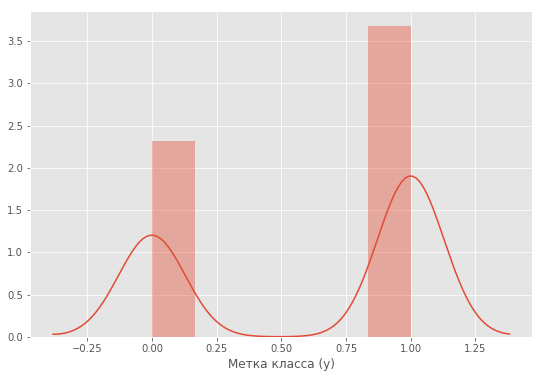

In [84]:
sns.distplot(y, axlabel='Метка класса (y)')

Посмотрим на пропуски в данных.

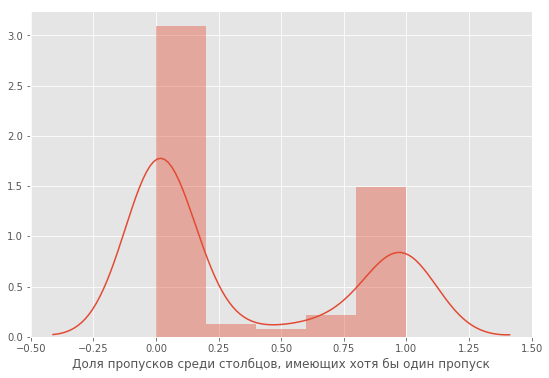

In [85]:
# Количество пропусков в столбцах
invalid = df.shape[0] - df.count()

# Выбросим столбцы без пропусков
missing = invalid[invalid > 0]

# В долях
missing_fraction = missing / df.shape[0]

# Ради наглядности построим гистограмму
sns.distplot(missing_fraction, axlabel='Доля пропусков среди столбцов, имеющих хотя бы один пропуск')

Наблюдается достаточно много столбцов с очень большим количеством пропусков. Выбросим столбцы, имеющие более 75% пропусков. Пропуски в остальных мы постараемся заполнить позже.

In [86]:
bad_columns = missing_fraction[missing_fraction > 0.75].index

df = df.drop(columns=bad_columns)
df_test = df_test.drop(columns=bad_columns)

Попробуем выделить среди признаков такие, которые скорее всего являются категориальными.

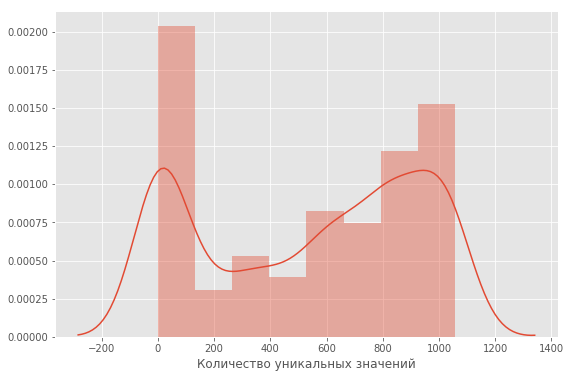

In [87]:
nunique = df.nunique()

sns.distplot(nunique, axlabel='Количество уникальных значений')

Выбросим признаки, имеющие единственное уникальное значение - они не несут совсем никакой смысловой нагрузки.

In [88]:
single_value_columns = nunique[nunique == 1].index

df = df.drop(columns=single_value_columns)
df_test = df_test.drop(columns=single_value_columns)

Наблюдается большое количество признаков, имеющих мало уникальных значений. Часть признаков, имеющих небольшое число уровней, скорее всего стоит интерпретировать как категориальные.

In [89]:
integer_columns = df.select_dtypes('int64')
int_nunique = integer_columns.nunique()

cat_feature_names = int_nunique[int_nunique <= 5].index
num_feature_names = list(set(df.columns) - set(cat_feature_names))

Пока что выделим в качестве категориальных признаки, имеющие от 2 до 5 уникальных значений. Возможно, мы с ними что-то сделаем в дальнейшем.

In [90]:
df.shape

(1095, 1349)

Итого у нас осталось 1349 признаков. Попробуем построить вложение наших данных высокой размерности в плоскость, чтобы визуализировать их распределение.

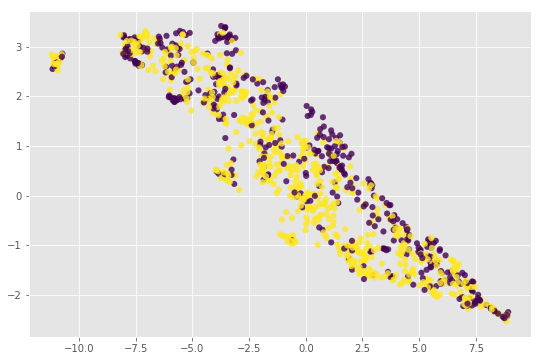

In [110]:
embedder = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('embedder', UMAP(n_neighbors=50,
                      metric='manhattan'))
])

embedding = embedder.fit_transform(df)

plt.scatter(embedding[:, 0], embedding[:, 1], c=y, linewidth=0.1, alpha=0.8)

Параметр `n_neighbors` был выставлен в максимальное "рекомендуемое" значение, чтобы сохранить большую часть 
глобальной структуры данных. Как видно из рендера вложения, нельзя сказать, что классы образуют какие-то чёткие кластеры. Однако, они не смешаны до степени неразличимости, а наоборот разделяются в том смысле, что на одной стороне "сгустка" преобладают элементы отрицательного класса, а на другой - положительного. Конечно, доверять таким проекциям сильно не стоит, но всё же есть надежда на неплохое качество классификации.

Для дальнейшей работы устроим разбиение на train- и test-выборки.

In [92]:
X = df
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

## Модели

### Логистическая регрессия

Попробуем для начала самую простую логистическую регрессию без попытки как-то закодировать категориальные признаки. Пропуски заполним медианой, а также стандартизуем признаки. Гиперпараметр регуляризации $C$ настроим при помощи кросс-валидации (воспользуемся `LogisticRegressionCV`).

In [18]:
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
lr = LogisticRegressionCV(cv=3, refit=True, scoring='roc_auc', class_weight='balanced', random_state=42)

baseline_lr = make_pipeline(imputer, scaler, lr)

In [19]:
baseline_lr.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('simpleimputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregressioncv', LogisticRegressionCV(Cs=10, class_weight='balanced', cv=3, dual=False,
...te=42,
           refit=True, scoring='roc_auc', solver='lbfgs', tol=0.0001,
           verbose=0))])

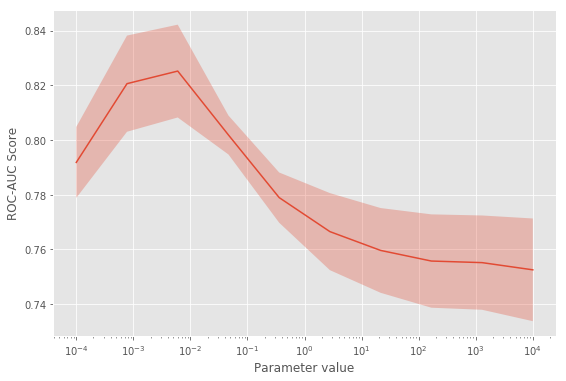

In [113]:
Cs = baseline_lr.steps[-1][1].Cs_
scores = baseline_lr.steps[-1][1].scores_[1.0]

plot_scores(Cs, scores, log=True)

In [21]:
score(baseline_lr, X_test, y_test)

ROC-AUC score for this model: 0.8775239728697278


In [22]:
submit(baseline_lr, df_test, 'logistic_regression_baseline_1')

Submission written to output/logistic_regression_baseline_1.csv


**Kaggle test score**: 0.87193

### SVM

Попробуем использовать для классификации метод опорных векторов.

In [23]:
svc = SVC(gamma='scale',
          kernel='rbf',
          C=1.5,
          class_weight='balanced',
          probability=True)

svc_clf = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('clf', svc)
])

In [24]:
svc_clf.fit(X_train, y_train)
score(svc_clf, X_test, y_test)

ROC-AUC score for this model: 0.8723006158883605


Предварительно было проверено, что единственное ядро, которое даёт нормальные результаты - это radial basis function (rbf). Поэтому гиперпараметры будем подбирать для него.

In [25]:
svm_grid = {
    'clf__C': np.logspace(-2, 3, 10)
}

rsearch_svm = RandomizedSearchCV(svc_clf,
                                 svm_grid,
                                 n_iter=100,
                                 scoring='roc_auc',
                                 verbose=10**9)

rsearch_svm.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] clf__C=0.01 .....................................................
[CV] ............. clf__C=0.01, score=0.740011580775912, total=   2.8s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s
[CV] clf__C=0.01 .....................................................
[CV] ............ clf__C=0.01, score=0.7602305102305102, total=   2.8s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s
[CV] clf__C=0.01 .....................................................
[CV] ............ clf__C=0.01, score=0.7921522921522922, total=   2.8s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.8s remaining:    0.0s
[CV] clf__C=0.03593813663804628 ......................................
[CV]  clf__C=0.03593813663804628, score=0.740011580775912, total=   2.8s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elap

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', SVC(C=1.5, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
          fit_params=None, iid='warn', n_iter=100, n_jobs=None,
          param_distributions={'clf__C': array([1.00000e-02, 3.59381e-02, 1.29155e-01, 4.64159e-01, 1.66810e+00,
       5.99484e+00, 2.15443e+01, 7.74264e+01, 2.78256e+02, 1.00000e+03])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=1000000000)

In [26]:
score(rsearch_svm, X_test, y_test)

ROC-AUC score for this model: 0.8707414048491463


Качество сильно не изменилось.

In [27]:
best_svm = clone(rsearch_svm.best_estimator_)
best_svm.fit(X, y)
submit(best_svm, df_test, 'svm_1')

Submission written to output/svm_1.csv


**Kaggle test score**: 0.87288

### Случайные леса

In [28]:
rfc = RandomForestClassifier(n_estimators=1000,
                             class_weight='balanced')

rf_clf = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('clf', rfc)
])

In [29]:
rf_grid = {
    'clf__bootstrap': [True, False],
    'clf__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'clf__max_features': ['auto', 'sqrt'],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__min_samples_split': [2, 5, 10],
    'clf__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}

rsearch_rf = RandomizedSearchCV(rf_clf,
                                rf_grid,
                                n_iter=100,
                                scoring='roc_auc',
                                verbose=10**9)

rsearch_rf.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] clf__n_estimators=2000, clf__min_samples_split=10, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=70, clf__bootstrap=False 
[CV]  clf__n_estimators=2000, clf__min_samples_split=10, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=70, clf__bootstrap=False, score=0.8138711960368011, total=  16.9s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.1s remaining:    0.0s
[CV] clf__n_estimators=2000, clf__min_samples_split=10, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=70, clf__bootstrap=False 
[CV]  clf__n_estimators=2000, clf__min_samples_split=10, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=70, clf__bootstrap=False, score=0.8444703444703445, total=  17.2s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   34.5s remaining:    0.0s
[CV] clf__n_estimators=2000, c

[CV]  clf__n_estimators=800, clf__min_samples_split=10, clf__min_samples_leaf=1, clf__max_features=sqrt, clf__max_depth=30, clf__bootstrap=False, score=0.8550893550893551, total=   7.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:  3.1min remaining:    0.0s
[CV] clf__n_estimators=1600, clf__min_samples_split=2, clf__min_samples_leaf=1, clf__max_features=auto, clf__max_depth=80, clf__bootstrap=False 
[CV]  clf__n_estimators=1600, clf__min_samples_split=2, clf__min_samples_leaf=1, clf__max_features=auto, clf__max_depth=80, clf__bootstrap=False, score=0.8136138454609794, total=  14.5s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:  3.3min remaining:    0.0s
[CV] clf__n_estimators=1600, clf__min_samples_split=2, clf__min_samples_leaf=1, clf__max_features=auto, clf__max_depth=80, clf__bootstrap=False 
[CV]  clf__n_estimators=1600, clf__min_samples_split=2, clf__min_samples_leaf=1, clf__max_features=auto, clf__max_depth=80, clf__bootstrap=False, score=0.8483553483553483, total=

[CV]  clf__n_estimators=1200, clf__min_samples_split=2, clf__min_samples_leaf=1, clf__max_features=sqrt, clf__max_depth=40, clf__bootstrap=False, score=0.8528878528878528, total=  10.9s
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:  6.1min remaining:    0.0s
[CV] clf__n_estimators=1200, clf__min_samples_split=5, clf__min_samples_leaf=2, clf__max_features=sqrt, clf__max_depth=80, clf__bootstrap=False 
[CV]  clf__n_estimators=1200, clf__min_samples_split=5, clf__min_samples_leaf=2, clf__max_features=sqrt, clf__max_depth=80, clf__bootstrap=False, score=0.814385897188445, total=  10.3s
[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:  6.3min remaining:    0.0s
[CV] clf__n_estimators=1200, clf__min_samples_split=5, clf__min_samples_leaf=2, clf__max_features=sqrt, clf__max_depth=80, clf__bootstrap=False 
[CV]  clf__n_estimators=1200, clf__min_samples_split=5, clf__min_samples_leaf=2, clf__max_features=sqrt, clf__max_depth=80, clf__bootstrap=False, score=0.847060347060347, total=  

[CV]  clf__n_estimators=800, clf__min_samples_split=10, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=30, clf__bootstrap=True, score=0.8384485884485884, total=   4.3s
[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:  8.6min remaining:    0.0s
[CV] clf__n_estimators=800, clf__min_samples_split=10, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=30, clf__bootstrap=True 
[CV]  clf__n_estimators=800, clf__min_samples_split=10, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=30, clf__bootstrap=True, score=0.8505568505568506, total=   4.3s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:  8.7min remaining:    0.0s
[CV] clf__n_estimators=1800, clf__min_samples_split=2, clf__min_samples_leaf=2, clf__max_features=sqrt, clf__max_depth=50, clf__bootstrap=True 
[CV]  clf__n_estimators=1800, clf__min_samples_split=2, clf__min_samples_leaf=2, clf__max_features=sqrt, clf__max_depth=50, clf__bootstrap=True, score=0.8069227304896094, total=   9.

[CV]  clf__n_estimators=1800, clf__min_samples_split=2, clf__min_samples_leaf=1, clf__max_features=auto, clf__max_depth=70, clf__bootstrap=True, score=0.8127452872675802, total=  10.4s
[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed: 10.9min remaining:    0.0s
[CV] clf__n_estimators=1800, clf__min_samples_split=2, clf__min_samples_leaf=1, clf__max_features=auto, clf__max_depth=70, clf__bootstrap=True 
[CV]  clf__n_estimators=1800, clf__min_samples_split=2, clf__min_samples_leaf=1, clf__max_features=auto, clf__max_depth=70, clf__bootstrap=True, score=0.8452149702149703, total=  10.7s
[Parallel(n_jobs=1)]: Done  83 out of  83 | elapsed: 11.0min remaining:    0.0s
[CV] clf__n_estimators=1800, clf__min_samples_split=2, clf__min_samples_leaf=1, clf__max_features=auto, clf__max_depth=70, clf__bootstrap=True 
[CV]  clf__n_estimators=1800, clf__min_samples_split=2, clf__min_samples_leaf=1, clf__max_features=auto, clf__max_depth=70, clf__bootstrap=True, score=0.8544742294742295, total=  10.

[CV]  clf__n_estimators=1400, clf__min_samples_split=5, clf__min_samples_leaf=4, clf__max_features=auto, clf__max_depth=40, clf__bootstrap=False, score=0.8552188552188553, total=  11.1s
[Parallel(n_jobs=1)]: Done 102 out of 102 | elapsed: 13.3min remaining:    0.0s
[CV] clf__n_estimators=1200, clf__min_samples_split=5, clf__min_samples_leaf=1, clf__max_features=sqrt, clf__max_depth=20, clf__bootstrap=True 
[CV]  clf__n_estimators=1200, clf__min_samples_split=5, clf__min_samples_leaf=1, clf__max_features=sqrt, clf__max_depth=20, clf__bootstrap=True, score=0.809560573891784, total=   6.9s
[Parallel(n_jobs=1)]: Done 103 out of 103 | elapsed: 13.4min remaining:    0.0s
[CV] clf__n_estimators=1200, clf__min_samples_split=5, clf__min_samples_leaf=1, clf__max_features=sqrt, clf__max_depth=20, clf__bootstrap=True 
[CV]  clf__n_estimators=1200, clf__min_samples_split=5, clf__min_samples_leaf=1, clf__max_features=sqrt, clf__max_depth=20, clf__bootstrap=True, score=0.8434990934990936, total=   6.

[CV]  clf__n_estimators=1000, clf__min_samples_split=5, clf__min_samples_leaf=1, clf__max_features=auto, clf__max_depth=80, clf__bootstrap=True, score=0.8552188552188553, total=   5.8s
[Parallel(n_jobs=1)]: Done 123 out of 123 | elapsed: 15.2min remaining:    0.0s
[CV] clf__n_estimators=1200, clf__min_samples_split=2, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=100, clf__bootstrap=True 
[CV]  clf__n_estimators=1200, clf__min_samples_split=2, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=100, clf__bootstrap=True, score=0.8107829891269381, total=   6.6s
[Parallel(n_jobs=1)]: Done 124 out of 124 | elapsed: 15.3min remaining:    0.0s
[CV] clf__n_estimators=1200, clf__min_samples_split=2, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=100, clf__bootstrap=True 
[CV]  clf__n_estimators=1200, clf__min_samples_split=2, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=100, clf__bootstrap=True, score=0.841038591038591, total=  

[CV]  clf__n_estimators=1200, clf__min_samples_split=10, clf__min_samples_leaf=1, clf__max_features=auto, clf__max_depth=50, clf__bootstrap=False, score=0.8455063455063454, total=  10.8s
[Parallel(n_jobs=1)]: Done 143 out of 143 | elapsed: 17.0min remaining:    0.0s
[CV] clf__n_estimators=1200, clf__min_samples_split=10, clf__min_samples_leaf=1, clf__max_features=auto, clf__max_depth=50, clf__bootstrap=False 
[CV]  clf__n_estimators=1200, clf__min_samples_split=10, clf__min_samples_leaf=1, clf__max_features=auto, clf__max_depth=50, clf__bootstrap=False, score=0.855995855995856, total=  10.6s
[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 17.2min remaining:    0.0s
[CV] clf__n_estimators=400, clf__min_samples_split=2, clf__min_samples_leaf=4, clf__max_features=sqrt, clf__max_depth=10, clf__bootstrap=False 
[CV]  clf__n_estimators=400, clf__min_samples_split=2, clf__min_samples_leaf=4, clf__max_features=sqrt, clf__max_depth=10, clf__bootstrap=False, score=0.8168307276587532, total=

[CV]  clf__n_estimators=1800, clf__min_samples_split=5, clf__min_samples_leaf=4, clf__max_features=sqrt, clf__max_depth=None, clf__bootstrap=False, score=0.8431753431753432, total=  14.5s
[Parallel(n_jobs=1)]: Done 164 out of 164 | elapsed: 19.8min remaining:    0.0s
[CV] clf__n_estimators=1800, clf__min_samples_split=5, clf__min_samples_leaf=4, clf__max_features=sqrt, clf__max_depth=None, clf__bootstrap=False 
[CV]  clf__n_estimators=1800, clf__min_samples_split=5, clf__min_samples_leaf=4, clf__max_features=sqrt, clf__max_depth=None, clf__bootstrap=False, score=0.8574851074851075, total=  14.2s
[Parallel(n_jobs=1)]: Done 165 out of 165 | elapsed: 20.1min remaining:    0.0s
[CV] clf__n_estimators=600, clf__min_samples_split=5, clf__min_samples_leaf=2, clf__max_features=sqrt, clf__max_depth=80, clf__bootstrap=True 
[CV]  clf__n_estimators=600, clf__min_samples_split=5, clf__min_samples_leaf=2, clf__max_features=sqrt, clf__max_depth=80, clf__bootstrap=True, score=0.8101396126873834, tota

[CV]  clf__n_estimators=1200, clf__min_samples_split=5, clf__min_samples_leaf=1, clf__max_features=sqrt, clf__max_depth=80, clf__bootstrap=True, score=0.8102039503313389, total=   6.9s
[Parallel(n_jobs=1)]: Done 184 out of 184 | elapsed: 22.5min remaining:    0.0s
[CV] clf__n_estimators=1200, clf__min_samples_split=5, clf__min_samples_leaf=1, clf__max_features=sqrt, clf__max_depth=80, clf__bootstrap=True 
[CV]  clf__n_estimators=1200, clf__min_samples_split=5, clf__min_samples_leaf=1, clf__max_features=sqrt, clf__max_depth=80, clf__bootstrap=True, score=0.8412328412328411, total=   7.0s
[Parallel(n_jobs=1)]: Done 185 out of 185 | elapsed: 22.6min remaining:    0.0s
[CV] clf__n_estimators=1200, clf__min_samples_split=5, clf__min_samples_leaf=1, clf__max_features=sqrt, clf__max_depth=80, clf__bootstrap=True 
[CV]  clf__n_estimators=1200, clf__min_samples_split=5, clf__min_samples_leaf=1, clf__max_features=sqrt, clf__max_depth=80, clf__bootstrap=True, score=0.8501683501683501, total=   6.

[CV]  clf__n_estimators=1200, clf__min_samples_split=2, clf__min_samples_leaf=1, clf__max_features=sqrt, clf__max_depth=50, clf__bootstrap=False, score=0.8134208325291128, total=  10.9s
[Parallel(n_jobs=1)]: Done 205 out of 205 | elapsed: 25.7min remaining:    0.0s
[CV] clf__n_estimators=1200, clf__min_samples_split=2, clf__min_samples_leaf=1, clf__max_features=sqrt, clf__max_depth=50, clf__bootstrap=False 
[CV]  clf__n_estimators=1200, clf__min_samples_split=2, clf__min_samples_leaf=1, clf__max_features=sqrt, clf__max_depth=50, clf__bootstrap=False, score=0.8452797202797202, total=  11.1s
[Parallel(n_jobs=1)]: Done 206 out of 206 | elapsed: 25.9min remaining:    0.0s
[CV] clf__n_estimators=1200, clf__min_samples_split=2, clf__min_samples_leaf=1, clf__max_features=sqrt, clf__max_depth=50, clf__bootstrap=False 
[CV]  clf__n_estimators=1200, clf__min_samples_split=2, clf__min_samples_leaf=1, clf__max_features=sqrt, clf__max_depth=50, clf__bootstrap=False, score=0.8536324786324785, total=

[CV]  clf__n_estimators=400, clf__min_samples_split=5, clf__min_samples_leaf=4, clf__max_features=sqrt, clf__max_depth=None, clf__bootstrap=True, score=0.8451825951825953, total=   2.0s
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed: 27.4min remaining:    0.0s
[CV] clf__n_estimators=1200, clf__min_samples_split=10, clf__min_samples_leaf=1, clf__max_features=auto, clf__max_depth=30, clf__bootstrap=True 
[CV]  clf__n_estimators=1200, clf__min_samples_split=10, clf__min_samples_leaf=1, clf__max_features=auto, clf__max_depth=30, clf__bootstrap=True, score=0.8102682879752944, total=   6.7s
[Parallel(n_jobs=1)]: Done 226 out of 226 | elapsed: 27.5min remaining:    0.0s
[CV] clf__n_estimators=1200, clf__min_samples_split=10, clf__min_samples_leaf=1, clf__max_features=auto, clf__max_depth=30, clf__bootstrap=True 
[CV]  clf__n_estimators=1200, clf__min_samples_split=10, clf__min_samples_leaf=1, clf__max_features=auto, clf__max_depth=30, clf__bootstrap=True, score=0.8386428386428387, total=

[CV]  clf__n_estimators=200, clf__min_samples_split=2, clf__min_samples_leaf=1, clf__max_features=sqrt, clf__max_depth=100, clf__bootstrap=False, score=0.8535353535353536, total=   1.9s
[Parallel(n_jobs=1)]: Done 246 out of 246 | elapsed: 30.1min remaining:    0.0s
[CV] clf__n_estimators=1600, clf__min_samples_split=5, clf__min_samples_leaf=2, clf__max_features=sqrt, clf__max_depth=40, clf__bootstrap=True 
[CV]  clf__n_estimators=1600, clf__min_samples_split=5, clf__min_samples_leaf=2, clf__max_features=sqrt, clf__max_depth=40, clf__bootstrap=True, score=0.8111046773467155, total=   8.6s
[Parallel(n_jobs=1)]: Done 247 out of 247 | elapsed: 30.2min remaining:    0.0s
[CV] clf__n_estimators=1600, clf__min_samples_split=5, clf__min_samples_leaf=2, clf__max_features=sqrt, clf__max_depth=40, clf__bootstrap=True 
[CV]  clf__n_estimators=1600, clf__min_samples_split=5, clf__min_samples_leaf=2, clf__max_features=sqrt, clf__max_depth=40, clf__bootstrap=True, score=0.842074592074592, total=   8.

[CV]  clf__n_estimators=1600, clf__min_samples_split=5, clf__min_samples_leaf=4, clf__max_features=sqrt, clf__max_depth=50, clf__bootstrap=False, score=0.8563843563843563, total=  12.6s
[Parallel(n_jobs=1)]: Done 267 out of 267 | elapsed: 32.5min remaining:    0.0s
[CV] clf__n_estimators=1800, clf__min_samples_split=2, clf__min_samples_leaf=1, clf__max_features=sqrt, clf__max_depth=30, clf__bootstrap=False 
[CV]  clf__n_estimators=1800, clf__min_samples_split=2, clf__min_samples_leaf=1, clf__max_features=sqrt, clf__max_depth=30, clf__bootstrap=False, score=0.8145467412983337, total=  16.3s
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed: 32.8min remaining:    0.0s
[CV] clf__n_estimators=1800, clf__min_samples_split=2, clf__min_samples_leaf=1, clf__max_features=sqrt, clf__max_depth=30, clf__bootstrap=False 
[CV]  clf__n_estimators=1800, clf__min_samples_split=2, clf__min_samples_leaf=1, clf__max_features=sqrt, clf__max_depth=30, clf__bootstrap=False, score=0.8490999740999741, total=

[CV]  clf__n_estimators=1000, clf__min_samples_split=2, clf__min_samples_leaf=4, clf__max_features=auto, clf__max_depth=80, clf__bootstrap=True, score=0.8381248381248381, total=   4.9s
[Parallel(n_jobs=1)]: Done 287 out of 287 | elapsed: 35.3min remaining:    0.0s
[CV] clf__n_estimators=1000, clf__min_samples_split=2, clf__min_samples_leaf=4, clf__max_features=auto, clf__max_depth=80, clf__bootstrap=True 
[CV]  clf__n_estimators=1000, clf__min_samples_split=2, clf__min_samples_leaf=4, clf__max_features=auto, clf__max_depth=80, clf__bootstrap=True, score=0.8513986013986014, total=   5.0s
[Parallel(n_jobs=1)]: Done 288 out of 288 | elapsed: 35.4min remaining:    0.0s
[CV] clf__n_estimators=400, clf__min_samples_split=5, clf__min_samples_leaf=4, clf__max_features=sqrt, clf__max_depth=90, clf__bootstrap=False 
[CV]  clf__n_estimators=400, clf__min_samples_split=5, clf__min_samples_leaf=4, clf__max_features=sqrt, clf__max_depth=90, clf__bootstrap=False, score=0.8133564948851574, total=   3.

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)), ('clf', RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impu...rs=1000, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False))]),
          fit_params=None, iid='warn', n_iter=100, n_jobs=None,
          param_distributions={'clf__bootstrap': [True, False], 'clf__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'clf__max_features': ['auto', 'sqrt'], 'clf__min_samples_leaf': [1, 2, 4], 'clf__min_samples_split': [2, 5, 10], 'clf__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='

Лучшие параметры:

In [30]:
rsearch_rf.best_params_

{'clf__n_estimators': 1400,
 'clf__min_samples_split': 2,
 'clf__min_samples_leaf': 2,
 'clf__max_features': 'auto',
 'clf__max_depth': 90,
 'clf__bootstrap': False}

In [31]:
rf_clf = clone(rsearch_rf.best_estimator_)
rf_clf.fit(X_train, y_train)

score(rf_clf, X_test, y_test)

ROC-AUC score for this model: 0.8600608092305294


In [32]:
rf_clf.fit(X, y)

submit(rf_clf, df_test, 'random_forest_1')

Submission written to output/random_forest_1.csv


**Kaggle test score**: 0.88470

### Градиентный бустинг

Попробуем более сложную и продвинутую модель - градиентный бустинг над деревьями решений. Воспользуемся CatBoost. На этот раз будем интерпретировать выявленные ранее признаки с 2-5 уровнями как категориальные, передав информацию об этом CatBoost. Соответственно, пропуски в этих признаках заполнять мы теперь будем не медианой, а модой.

In [66]:
imputer = ColumnTransformer([
    ('cat_imputer', SimpleImputer(strategy='most_frequent'), cat_feature_names),
    ('num_imputer', SimpleImputer(strategy='median'), num_feature_names)
], remainder='passthrough')

CAT_FEATURES = list(range(len(cat_feature_names)))
clf = CatBoostClassifierWrapper(logging_level='Silent',
                                cat_features=CAT_FEATURES)

gb_clf = Pipeline([
    ('imputer', imputer),
    ('clf', clf)
])

In [60]:
gb_clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('imputer', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('cat_imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='most_frequent', verbose=0), Index(['f485', 'f488',...', 'f661'])])), ('clf', CatBoostClassifierWrapper(logging_level='Silent', loss_function='Logloss'))])

In [61]:
score(gb_clf, X_test, y_test)

ROC-AUC score for this model: 0.8820846651594294


In [62]:
gb_clf.fit(X, y)

submit(gb_clf, df_test, 'grad_boosting_1')

Submission written to output/grad_boosting_1.csv


**Kaggle test score**: 0.89725

Попробуем настроить гиперпараметры алгоритма. Начнём, с числа итераций.

In [37]:
iter_grid = {    
    'clf__iterations': [1, 10, 50, 100, 150, 200, 250, 300, 350, 400, 600, 800, 1000]
}

gsearch_gb_iter = GridSearchCV(gb_clf,
                       iter_grid,
                       scoring='roc_auc',
                       cv=3,
                       return_train_score=True,
                       verbose=10**9)

gsearch_gb_iter.fit(X_train, y_train)

Fitting 3 folds for each of 13 candidates, totalling 39 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] clf__iterations=1 ...............................................
[CV] ...... clf__iterations=1, score=0.7038216560509554, total=   0.6s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[CV] clf__iterations=1 ...............................................
[CV] ...... clf__iterations=1, score=0.7620758870758871, total=   0.6s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[CV] clf__iterations=1 ...............................................
[CV] ...... clf__iterations=1, score=0.7656371406371406, total=   0.6s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s
[CV] clf__iterations=10 ..............................................
[CV] ..... clf__iterations=10, score=0.8042848870874348, total=   2.1s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapse

[CV] ... clf__iterations=1000, score=0.8211413498037702, total= 3.5min
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed: 30.2min remaining:    0.0s
[CV] clf__iterations=1000 ............................................
[CV] ... clf__iterations=1000, score=0.8569023569023568, total= 3.3min
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed: 33.5min remaining:    0.0s
[CV] clf__iterations=1000 ............................................
[CV] ... clf__iterations=1000, score=0.8693991193991193, total= 2.8min
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed: 36.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed: 36.2min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('imputer', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('cat_imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='most_frequent', verbose=0), Index(['f485', 'f488',...(iterations=400, learning_rate=0.03,
             logging_level='Silent', loss_function='Logloss'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'clf__iterations': [1, 10, 50, 100, 150, 200, 250, 300, 350, 400, 600, 800, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1000000000)

Посмотрим, как меняется оценка с ростом числа итераций.

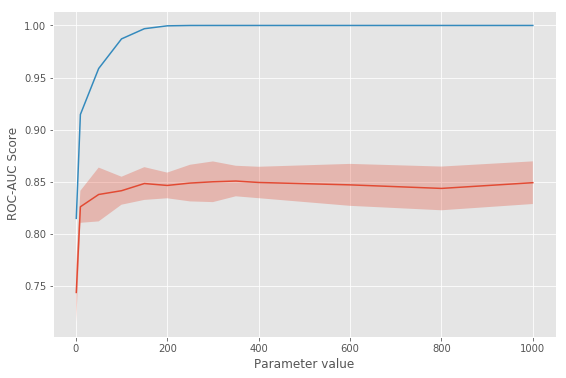

In [112]:
mean_scores_iter = gsearch_gb_iter.cv_results_['mean_test_score']
std_scores_iter = gsearch_gb_iter.cv_results_['std_test_score']
train_scores_iter = gsearch_gb_iter.cv_results_['mean_train_score']

plot_scores(iter_grid['clf__iterations'],
            mean_scores_iter, std_scores_iter, train_scores_iter)

Хоть поиск и показывает, что лучшее значение количества итераций - это 600, по графикам особых различий в диапазоне 400-1000 не наблюдается, поэтому будем использовать `iterations=400`, чтобы ускорить обучение в дальнейшем.

In [70]:
gb_clf.set_params(clf__iterations=400)
gb_clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('imputer', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('cat_imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='most_frequent', verbose=0), Index(['f485', 'f488',...ostClassifierWrapper(iterations=400, logging_level='Silent',
             loss_function='Logloss'))])

In [71]:
score(gb_clf, X_test, y_test)

ROC-AUC score for this model: 0.8773290714898261


In [72]:
gb_clf.fit(X, y)
submit(gb_clf, df_test, 'grad_boosting_2')

Submission written to output/grad_boosting_2.csv


**Kaggle test score**: 0.90577

Локально качество несколько упало, однако по оценке Kaggle оно заметно возросло.

Попробуем теперь настроить максимальную глубину каждого решающего дерева в ансамбле.

In [46]:
depth_grid = {
    'clf__depth': [5, 6, 7, 8, 9]
}

gsearch_depth = GridSearchCV(gb_clf,
                       depth_grid,
                       scoring='roc_auc',
                       cv=3,
                       return_train_score=True,
                       verbose=10**9)

gsearch_depth.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] clf__depth=5 ....................................................
[CV] ........... clf__depth=5, score=0.8286688541465612, total=  31.1s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.2s remaining:    0.0s
[CV] clf__depth=5 ....................................................
[CV] ........... clf__depth=5, score=0.8514633514633514, total=  31.7s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s
[CV] clf__depth=5 ....................................................
[CV] ............ clf__depth=5, score=0.861952861952862, total=  31.7s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min remaining:    0.0s
[CV] clf__depth=6 ....................................................
[CV] ........... clf__depth=6, score=0.8253232966608762, total=  54.4s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('imputer', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('cat_imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='most_frequent', verbose=0), Index(['f485', 'f488',...(iterations=300, learning_rate=0.03,
             logging_level='Silent', loss_function='Logloss'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'clf__depth': [5, 6, 7, 8, 9]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='roc_auc',
       verbose=1000000000)

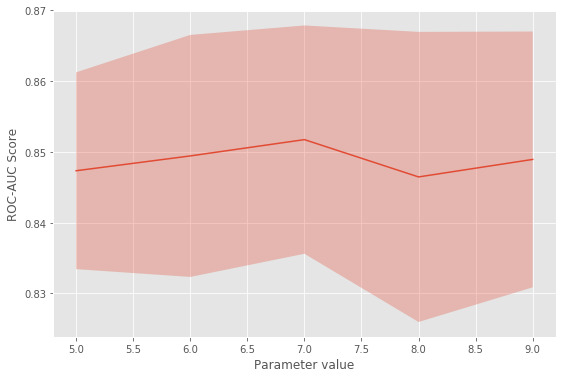

In [111]:
mean_scores_depth = gsearch_depth.cv_results_['mean_test_score']
std_scores_depth = gsearch_depth.cv_results_['std_test_score']
train_scores_depth = gsearch_depth.cv_results_['mean_train_score']

plot_scores(depth_grid['clf__depth'],
            mean_scores_depth, std_scores_depth)

In [51]:
best_gb_clf = clone(gsearch_depth.best_estimator_)

best_gb_clf.fit(X_train, y_train)
score(best_gb_clf, X_test, y_test)

ROC-AUC score for this model: 0.8670382786310127


In [52]:
best_gb_clf.fit(X, y)
submit(best_gb_clf, df_test, 'grad_boosting_3')

Submission written to output/grad_boosting_3.csv


**Kaggle test score**: 0.89882

Качество и при локальной оценке, и при оценке Kaggle заметно упало. Поэтому здесь настройки, видимо, стоит оставить "по умолчанию".

## Вывод 

Было рассмотрено четыре модели в порядке возрастания их "сложности". Для каждой модели были подобраны близкие к оптимальным значения её гиперпараметров. Результаты тестирования представлены в следующей таблице:


|          Модель         | Kaggle test   ROC-AUC |
|-------------------------|-----------------------|
| Логистическая регрессия |        0.87193        |
| Метод опорных векторов  |        0.87288        |
| Случайный лес           |        0.88470        |
| Градиентный бустинг     |        0.90577        |

Лучшей по качеству классификации оказалась самая сложная модель градиентного бустинга, оставив своих конкурентов далеко позади.